# Purpose
- goal is to use DLC-estimated key points and define behavioral epochs
- data is from Alex F from Knowles lab, and we want to quanitfy:

1. time in light box (time visible)
    - nose only
    - nose and ears
    - nose and ears and butt
2. distance to edge IN REAL COORDINATES
    - adjust marked coordinates to real coordinates (50cm2 box)
    - get animal position relative to corners
3. #, timing, location of rearing events
4. #, timing, location of jumps


# imports

In [1]:
import numpy as np
import pandas as pd
import glob, os, csv
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from scipy.io import arff
import math

In [4]:
import itertools

# functions

In [5]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                for idx in np.arange(0,len(part.x)):
                    second_idx = np.max([0,idx-1])
                    if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                        part.y[idx] = np.nan
                    elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                        part.x[idx] = np.nan
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                part.x = part.x.interpolate()
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                part.y = part.y.interpolate()
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [6]:
def align_df(df):
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# load an example file, preprocess data (exclude outliers, smooth)

In [124]:
num=33

filename = "../data/{}DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv".format(num)
#filename = "/home/dennislab2/Desktop/videos/skok_alex_videos/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"
df = pd.read_csv(filename,header=[1,2])
df

bodyparts      box_tl                              box_tr              \
         coords           x           y likelihood            x           y   
0             0  591.654419   76.160820   0.999919  1419.758545   75.994919   
1             1  590.925049   75.757370   0.999920  1421.067627   76.313705   
2             2  590.408020   75.806763   0.999872  1421.225342   75.527191   
3             3  590.694763   75.732468   0.999915  1420.811646   75.643997   
4             4  589.754700   75.392036   0.999895  1420.593750   75.480797   
...         ...         ...         ...        ...          ...         ...   
17960     17960  695.168213  141.620209   0.999926  1527.529785  121.717766   
17961     17961  694.778931  141.034149   0.999944  1527.103638  122.170166   
17962     17962  695.574097  140.863159   0.999953  1528.324951  122.065781   
17963     17963  695.381775  141.333221   0.999929  1528.401733  122.169861   
17964     17964  695.165894  140.988358   0.999945  1528.192627  121.878624   

                      box_bl                         ... paw_left_front  \
      likelihood           x           y likelihood  ...     likelihood   
0       0.998421  594.195435  908.155884   0.999648  ...       0.002444   
1       0.997732  594.604431  906.817749   0.999717  ...       0.003115   
2       0.997475  594.780762  908.142151   0.999794  ...       0.003215   
3       0.996647  594.984314  907.973877   0.999755  ...       0.002098   
4       0.996650  594.881348  908.175232   0.999596  ...       0.002937   
...          ...         ...         ...        ...  ...            ...   
17960   0.999805  692.655151  962.900513   0.999954  ...       0.003116   
17961   0.999814  693.764343  962.753418   0.999939  ...       0.002804   
17962   0.999738  694.928711  963.342102   0.999946  ...       0.003069   
17963   0.999815  692.747803  962.899353   0.999961  ...       0.002760   
17964   0.999635  693.922058  963.416931   0.999955  ...       0.003533   

      paw_right_front                        paw_left_back              \
                    x           y likelihood             x           y   
0         1419.430542  892.671021   0.003316    589.111023  432.880585   
1          585.980408  539.962463   0.002913    589.032104  433.032928   
2          586.052368  539.761719   0.002677    589.212402  433.724396   
3          590.117676  909.719604   0.003046    589.062073  433.382294   
4         1419.381470  891.707092   0.002823    589.241638  432.929993   
...               ...         ...        ...           ...         ...   
17960      687.800171  959.455750   0.002849    695.433167  494.570679   
17961      695.208618  482.019897   0.002318    695.557983  494.319794   
17962      688.882629  958.687439   0.002515    695.647705  494.244598   
17963      687.809082  959.303711   0.002309    695.551697  494.405243   
17964      686.975769  956.750610   0.003624    696.019165  494.075256   

                 paw_right_back                         
      likelihood              x           y likelihood  
0       0.007330     588.470764  430.425446   0.009568  
1       0.008649     588.615784  430.395050   0.009171  
2       0.007539     582.487000  439.136108   0.011845  
3       0.007132     587.716736  435.036255   0.009708  
4       0.007881     588.961060  430.722687   0.007754  
...          ...            ...         ...        ...  
17960   0.004438    1528.033325  123.174530   0.009304  
17961   0.004345    1527.511475  123.402184   0.008857  
17962   0.003933    1527.812500  123.728767   0.007303  
17963   0.004330    1528.508301  123.415436   0.008529  
17964   0.003458    1528.592651  123.382431   0.007272  

[17965 rows x 46 columns]

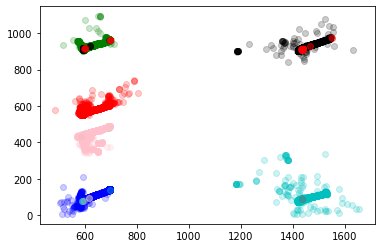

In [125]:
a=0
b=-1
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.2)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.2)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.2)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.2)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.2)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.2)
plt.show()

## which rolling window is "good" at discarding random jumps in assignment but still capturing the slides?

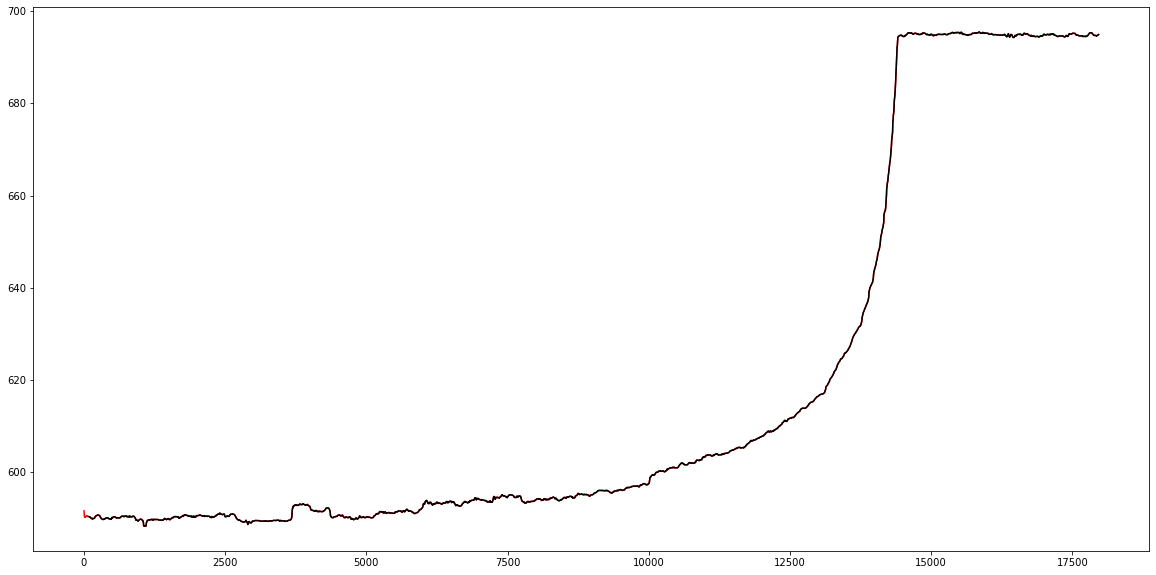

In [126]:
s = df.box_tl["x"]
seconds=3
fps=30
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps,min_periods=1).median(),c='r')
plt.plot(s.rolling(seconds*fps).median(),c='k')
#plt.xlim((0,100))
plt.show()

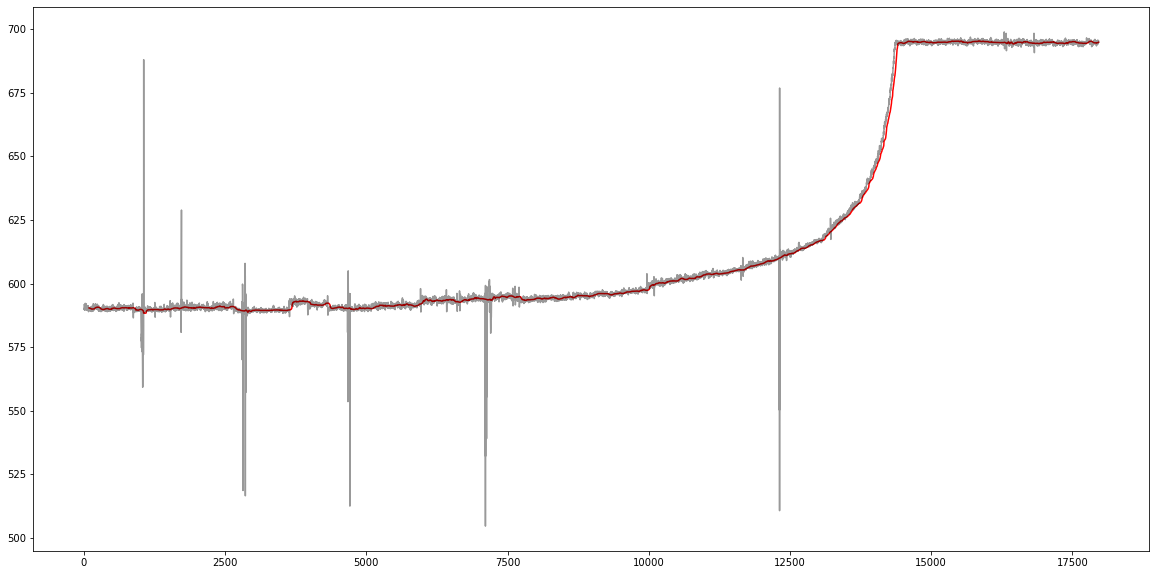

In [127]:
s = df.box_tl["x"]
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps).median(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.show()

### what adjustments do we need for body parts?

In [73]:
new_df=reformat_df(df,0.9,1000,15,3,30)

C:\Users\dennise\AppData\Local\Temp\ipykernel_22136\3168813908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df=reformat_df(df,0.9,1000,15,3,30)
C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [128]:
new_df

box_bl                              box_br                         \
                x           y likelihood            x           y likelihood   
0      823.463623  787.660400   0.999694  1288.769897  783.867981   0.998650   
1      823.484253  787.844208   0.999684  1288.778320  783.841187   0.998445   
2      823.504883  788.028015   0.999678  1288.786743  783.867981   0.998847   
3      823.484253  788.064636   0.999718  1288.814148  783.913361   0.998613   
4      823.463623  788.101257   0.999707  1288.786743  783.958740   0.998745   
...           ...         ...        ...          ...         ...        ...   
14416  869.503601  819.591003   0.999753  1353.681335  825.258484   0.198465   
14417  869.507751  819.600128   0.999752  1353.739807  825.258484   0.189202   
14418  869.517914  819.600128   0.999631  1353.798279  825.258484   0.205819   
14419  869.524506  819.600128   0.999740  1353.832642  825.258484   0.184471   
14420  869.526428  819.600128   0.999767  1353.861877  825.258484   0.163525   

           box_tl                              box_tr  ... paw_right_back  \
                x           y likelihood            x  ...     likelihood   
0      819.318298  323.623383   0.999966  1281.224121  ...       0.008822   
1      819.575775  323.843475   0.999971  1281.141846  ...       0.008862   
2      819.833252  324.063568   0.999968  1281.088379  ...       0.008344   
3      819.911835  324.031387   0.999967  1281.115356  ...       0.008217   
4      819.935303  324.063568   0.999967  1281.128174  ...       0.008578   
...           ...         ...        ...          ...  ...            ...   
14416  867.679810  355.522385   0.999979  1337.601257  ...       0.119489   
14417  867.679810  355.522385   0.999979  1337.610901  ...       0.166141   
14418  867.679810  355.522385   0.999980  1337.610901  ...       0.200084   
14419  867.679810  355.522385   0.999985  1337.610901  ...       0.229732   
14420  867.679810  355.522385   0.999985  1337.610901  ...       0.252032   

      paw_right_front                   tail_base                         \
                    x   y likelihood            x           y likelihood   
0                 NaN NaN   0.007948          NaN         NaN   0.008320   
1                 NaN NaN   0.008033          NaN         NaN   0.007539   
2                 NaN NaN   0.007906          NaN         NaN   0.006836   
3                 NaN NaN   0.008722          NaN         NaN   0.007532   
4                 NaN NaN   0.008372          NaN         NaN   0.007239   
...               ...  ..        ...          ...         ...        ...   
14416             NaN NaN   0.235560  1301.473755  777.344543   0.998798   
14417             NaN NaN   0.208303  1302.015869  777.314575   0.998581   
14418             NaN NaN   0.223339  1302.195923  776.935303   0.998464   
14419             NaN NaN   0.211104  1302.477051  776.985718   0.998222   
14420             NaN NaN   0.215210  1302.554810  776.908936   0.998138   

          tail_tip                         
                 x           y likelihood  
0              NaN         NaN   0.017635  
1              NaN         NaN   0.014370  
2              NaN         NaN   0.014855  
3              NaN         NaN   0.014145  
4              NaN         NaN   0.010465  
...            ...         ...        ...  
14416  1291.506470  705.527649   0.995354  
14417  1291.483765  705.630676   0.995839  
14418  1291.156982  705.754211   0.996005  
14419  1291.300415  705.596008   0.996222  
14420  1291.337646  705.795593   0.995707  

[14421 rows x 45 columns]

In [129]:
#filename[:-4]+"_adj.csv"
new_df.to_csv(filename[:-4]+"_adj.csv")

In [130]:
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)

In [131]:
new_df

box_bl                              box_br                         \
                x           y likelihood            x           y likelihood   
0      823.463623  787.660400   0.999694  1288.769897  783.867981   0.998650   
1      823.484253  787.844208   0.999684  1288.778320  783.841187   0.998445   
2      823.504883  788.028015   0.999678  1288.786743  783.867981   0.998847   
3      823.484253  788.064636   0.999718  1288.814148  783.913361   0.998613   
4      823.463623  788.101257   0.999707  1288.786743  783.958740   0.998745   
...           ...         ...        ...          ...         ...        ...   
14416  869.503601  819.591003   0.999753  1353.681335  825.258484   0.198465   
14417  869.507751  819.600128   0.999752  1353.739807  825.258484   0.189202   
14418  869.517914  819.600128   0.999631  1353.798279  825.258484   0.205819   
14419  869.524506  819.600128   0.999740  1353.832642  825.258484   0.184471   
14420  869.526428  819.600128   0.999767  1353.861877  825.258484   0.163525   

           box_tl                              box_tr  ... paw_right_back  \
                x           y likelihood            x  ...     likelihood   
0      819.318298  323.623383   0.999966  1281.224121  ...       0.008822   
1      819.575775  323.843475   0.999971  1281.141846  ...       0.008862   
2      819.833252  324.063568   0.999968  1281.088379  ...       0.008344   
3      819.911835  324.031387   0.999967  1281.115356  ...       0.008217   
4      819.935303  324.063568   0.999967  1281.128174  ...       0.008578   
...           ...         ...        ...          ...  ...            ...   
14416  867.679810  355.522385   0.999979  1337.601257  ...       0.119489   
14417  867.679810  355.522385   0.999979  1337.610901  ...       0.166141   
14418  867.679810  355.522385   0.999980  1337.610901  ...       0.200084   
14419  867.679810  355.522385   0.999985  1337.610901  ...       0.229732   
14420  867.679810  355.522385   0.999985  1337.610901  ...       0.252032   

      paw_right_front                   tail_base                         \
                    x   y likelihood            x           y likelihood   
0                 NaN NaN   0.007948          NaN         NaN   0.008320   
1                 NaN NaN   0.008033          NaN         NaN   0.007539   
2                 NaN NaN   0.007906          NaN         NaN   0.006836   
3                 NaN NaN   0.008722          NaN         NaN   0.007532   
4                 NaN NaN   0.008372          NaN         NaN   0.007239   
...               ...  ..        ...          ...         ...        ...   
14416             NaN NaN   0.235560  1301.473755  777.344543   0.998798   
14417             NaN NaN   0.208303  1302.015869  777.314575   0.998581   
14418             NaN NaN   0.223339  1302.195923  776.935303   0.998464   
14419             NaN NaN   0.211104  1302.477051  776.985718   0.998222   
14420             NaN NaN   0.215210  1302.554810  776.908936   0.998138   

          tail_tip                         
                 x           y likelihood  
0              NaN         NaN   0.017635  
1              NaN         NaN   0.014370  
2              NaN         NaN   0.014855  
3              NaN         NaN   0.014145  
4              NaN         NaN   0.010465  
...            ...         ...        ...  
14416  1291.506470  705.527649   0.995354  
14417  1291.483765  705.630676   0.995839  
14418  1291.156982  705.754211   0.996005  
14419  1291.300415  705.596008   0.996222  
14420  1291.337646  705.795593   0.995707  

[14421 rows x 45 columns]

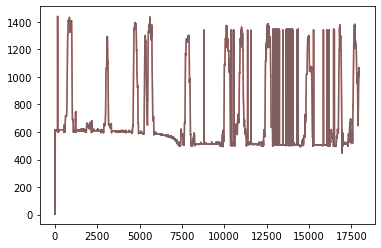

In [160]:
#plt.figure(figsize=(20,10))
#plt.plot(part.y,c='k')
plt.plot(part.x.interpolate(limit=15),c='r',alpha=1)
plt.plot(part.x.interpolate(limit=5),c='c',alpha=0.5)
plt.show()

# preprocessing thoughts 

let's say for now,
- for corners, rolling median of 90 (frames, 3 sec)
- interpolating between nans limit = 15 (.5 sec)

### ~TODO~ Done:
1. first, apply the above lessons to an entire dataframe, save it
2. should make box, and find region (in px) that correspond to 5 cm from edge (of the 50x50cm box)
3. extract useful info
    a. how much time did the animal spend visible?
        i. just nose?
        ii. nose + ears?
        iii. nose + ears + tail base?

## affine transform of points to correct for sliding FOV

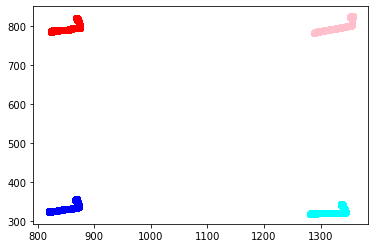

In [133]:
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='r') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='pink') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='cyan') #500,0mm

In [134]:
s1=[0,500]
s2=[500,500]
s3=[0,0]
s4=[500,0]
idx=1000
p1=[new_df.box_bl.x[idx],new_df.box_bl.y[idx]] #0,500
p2=[new_df.box_br.x[idx],new_df.box_br.y[idx]] #500,500
p3=[new_df.box_tl.x[idx],new_df.box_tl.y[idx]] #0,0
p4=[new_df.box_tr.x[idx],new_df.box_tr.y[idx]] #500,0
print(p1,p2,p3,p4)
print(s1,s2,s3,s4)

[825.0791320800781, 787.3692626953125] [1291.0576782226562, 784.5596313476562] [822.5401611328125, 324.8522186279297] [1282.98046875, 319.65428161621094]
[0, 500] [500, 500] [0, 0] [500, 0]


In [79]:
# get a transform matrix
A2 = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))

# set points
pts = np.array([[p1]],dtype='float32')

# use transform matrix to un-warp the points
cv2.perspectiveTransform(pts,A2)

array([[[-1.103288e-13,  5.000000e+02]]], dtype=float32)

In [80]:
aligned_df=align_df(new_df)
aligned_df

at 0 of 14421 rows
at 1000 of 14421 rows
at 2000 of 14421 rows
at 3000 of 14421 rows
at 4000 of 14421 rows
at 5000 of 14421 rows
at 6000 of 14421 rows
at 7000 of 14421 rows
at 8000 of 14421 rows
at 9000 of 14421 rows
at 10000 of 14421 rows
at 11000 of 14421 rows
at 12000 of 14421 rows
at 13000 of 14421 rows
at 14000 of 14421 rows


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0     -2.243271e-13  500.0   0.999694  500.0  500.0   0.998650 -3.389650e-13   
1     -1.119552e-13  500.0   0.999684  500.0  500.0   0.998445 -1.128578e-13   
2      0.000000e+00  500.0   0.999678  500.0  500.0   0.998847  0.000000e+00   
3      2.234336e-13  500.0   0.999718  500.0  500.0   0.998613  1.127140e-13   
4      0.000000e+00  500.0   0.999707  500.0  500.0   0.998745  1.127083e-13   
...             ...    ...        ...    ...    ...        ...           ...   
14416  0.000000e+00  500.0   0.999753  500.0  500.0   0.198465  0.000000e+00   
14417  0.000000e+00  500.0   0.999752  500.0  500.0   0.189202  0.000000e+00   
14418  0.000000e+00  500.0   0.999631  500.0  500.0   0.205819  2.051288e-13   
14419 -1.992907e-13  500.0   0.999740  500.0  500.0   0.184471 -2.051146e-13   
14420  0.000000e+00  500.0   0.999767  500.0  500.0   0.163525  0.000000e+00   

                               box_tr  ... paw_right_back paw_right_front      \
                  y likelihood      x  ...     likelihood               x   y   
0      0.000000e+00   0.999966  500.0  ...       0.008822             NaN NaN   
1     -1.128578e-13   0.999971  500.0  ...       0.008862             NaN NaN   
2     -5.635446e-14   0.999968  500.0  ...       0.008344             NaN NaN   
3     -5.635702e-14   0.999967  500.0  ...       0.008217             NaN NaN   
4      0.000000e+00   0.999967  500.0  ...       0.008578             NaN NaN   
...             ...        ...    ...  ...            ...             ...  ..   
14416 -1.025832e-13   0.999979  500.0  ...       0.119489             NaN NaN   
14417 -5.128718e-14   0.999979  500.0  ...       0.166141             NaN NaN   
14418  0.000000e+00   0.999980  500.0  ...       0.200084             NaN NaN   
14419 -5.127864e-14   0.999985  500.0  ...       0.229732             NaN NaN   
14420 -5.127537e-14   0.999985  500.0  ...       0.252032             NaN NaN   

                   tail_base                           tail_tip              \
      likelihood           x           y likelihood           x           y   
0       0.007948         NaN         NaN   0.008320         NaN         NaN   
1       0.008033         NaN         NaN   0.007539         NaN         NaN   
2       0.007906         NaN         NaN   0.006836         NaN         NaN   
3       0.008722         NaN         NaN   0.007532         NaN         NaN   
4       0.008372         NaN         NaN   0.007239         NaN         NaN   
...          ...         ...         ...        ...         ...         ...   
14416   0.235560  449.434052  452.097473   0.998798  441.572723  378.881714   
14417   0.208303  449.930542  452.067169   0.998581  441.505554  378.997345   
14418   0.223339  450.074615  451.685577   0.998464  441.132507  379.134247   
14419   0.211104  450.327118  451.737640   0.998222  441.259033  378.978088   
14420   0.215210  450.384003  451.662018   0.998138  441.271301  379.188446   

                  
      likelihood  
0       0.017635  
1       0.014370  
2       0.014855  
3       0.014145  
4       0.010465  
...          ...  
14416   0.995354  
14417   0.995839  
14418   0.996005  
14419   0.996222  
14420   0.995707  

[14421 rows x 45 columns]

### save out aligned data

In [135]:
#aligned_df.to_csv(filename[:-4]+"_aligned.csv")
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",index_col=0,header=[0,1])

### let's see what the data look like after adjustment

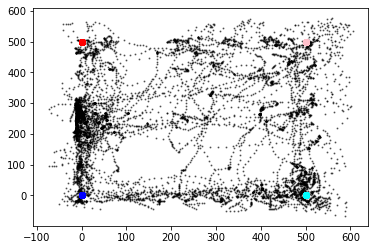

In [136]:
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.show()

In [84]:
nose_df = aligned_df.nose
nose_df

,x,y,likelihood
0,NaN,NaN,0.011615
1,NaN,NaN,0.011272
2,NaN,NaN,0.010711
3,NaN,NaN,0.010453
4,NaN,NaN,0.010857
...,...,...,...
14416,513.791748,487.628937,0.999626
14417,515.167542,487.342499,0.999271
14418,515.062134,487.491394,0.999363
14419,516.322754,488.645477,0.998466


### how much time did the animal spend in the box?


In [137]:
aligned_df = pd.read_csv('../data/{}DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned.csv'.format(num), index_col=0, header=[0,1])


In [142]:
17965/(29.93*60)

10.003897984185322

In [138]:
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

print("frames with nose: {}".format(np.sum(nose_vals)))
frames_with_nose = np.sum(nose_vals)
print("frames with nose and ears: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals)))
print("frames with nose and ears and tail: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals)))
print("total frames {}".format(len(nose_vals)))

frames with nose: 8654
frames with nose and ears: 8283
frames with nose and ears and tail: 7881
total frames 17965


C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


### how much time did it spend within 50mm of the 500mm^2 walls?


In [143]:
# can just use adj px values > 450 and < 50 (further vals are outside walls, but include jumps and rears which we do want to include)
nose_df=aligned_df.nose
#nose_df=nose_df[~np.isnan(nose_df.x)].reset_index()
nose_df['within50mm']=0
for idx in nose_df.index:
    xval=nose_df.x[idx]
    yval=nose_df.y[idx]
    if xval < 50 or xval > 450 or yval < 50 or yval > 450:
        nose_df.iloc[idx,3]=1
summed_val=np.sum(nose_df.within50mm)
print("frames with nose within 50mm of edge {}".format(summed_val))
print("fraction of frames with nose within 50mm of edge {}".format(summed_val/len(nose_df)))
print("fraction of frames where animal is inside the box AND within 50mm of an edge {}".format(summed_val/frames_with_nose))
print("fraction of frames where animal is inside and in the center (further than 50mm from an edge): {}".format((frames_with_nose-summed_val)/frames_with_nose))

C:\Users\dennise\AppData\Local\Temp\ipykernel_22136\3598521612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0


frames with nose within 50mm of edge 6905
fraction of frames with nose within 50mm of edge 0.3843584748121347
fraction of frames where animal is inside the box AND within 50mm of an edge 0.7978969262768661
fraction of frames where animal is inside and in the center (further than 50mm from an edge): 0.20210307372313382


In [147]:
#number of entrances
# Alex might have additionals

### find first frame where it enters the 'center' of the box

In [144]:
tstdf=nose_df[~np.isnan(nose_df.x)]
tstdf=tstdf[tstdf.within50mm<1]
print("first frame in center (> 50mm from edge): {}".format(tstdf.index[0]))

first frame in center (> 50mm from edge): 828


In [107]:
# plot points in adjusted space

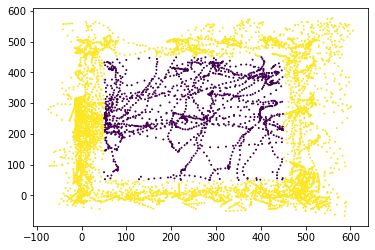

In [145]:
plt.scatter(nose_df.x,nose_df.y,c=nose_df.within50mm,s=1)

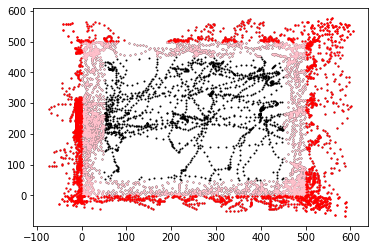

In [146]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)

## jump and rear classifications

In [148]:
filename

'../data/33DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv'

In [149]:
Alex_annot_filename = '../data/boris_events_{}.csv'.format(num)
annots=pd.read_csv(Alex_annot_filename,skiprows=14,header=1)
aligned_df=pd.read_csv(filename[:-4]+"_aligned_dists.csv",header=[0,1],index_col=0)
print(annots.head())
aligned_df.head()

     Time                                    Media file path  Total length  \
0  50.780  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        726.78   
1  51.280  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        726.78   
2  51.779  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        726.78   
3  52.030  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        726.78   
4  52.780  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        726.78   

     FPS  Subject Behavior  Behavioral category  Comment Status  
0  29.93      NaN    Light                  NaN      NaN  START  
1  29.93      NaN   Moving                  NaN      NaN  START  
2  29.93      NaN   Moving                  NaN      NaN   STOP  
3  29.93      NaN   Moving                  NaN      NaN  START  
4  29.93      NaN   Moving                  NaN      NaN   STOP  


box_bl                   box_br                          box_tl  \
              x      y likelihood      x      y likelihood             x   
0 -5.727973e-14  500.0   0.999648  500.0  500.0   0.999597 -1.143288e-13   
1  0.000000e+00  500.0   0.999717  500.0  500.0   0.999780 -5.717598e-14   
2 -5.753928e-14  500.0   0.999794  500.0  500.0   0.999789  0.000000e+00   
3  5.755104e-14  500.0   0.999755  500.0  500.0   0.999719  0.000000e+00   
4  0.000000e+00  500.0   0.999596  500.0  500.0   0.999642  0.000000e+00   

                           box_tr  ...   tail_tip          dists  \
              y likelihood      x  ... likelihood nose_ear_right   
0  3.572775e-14   0.999919  500.0  ...   0.068285            NaN   
1 -5.002898e-14   0.999920  500.0  ...   0.095745            NaN   
2  7.154222e-15   0.999872  500.0  ...   0.066341            NaN   
3  0.000000e+00   0.999915  500.0  ...   0.103802            NaN   
4  0.000000e+00   0.999895  500.0  ...   0.065217            NaN   

                                                                            \
  nose_ear_left nose_paw_left_back nose_paw_left_front nose_paw_right_back   
0           NaN                NaN                 NaN                 NaN   
1           NaN                NaN                 NaN                 NaN   
2           NaN                NaN                 NaN                 NaN   
3           NaN                NaN                 NaN                 NaN   
4           NaN                NaN                 NaN                 NaN   

                                                                  speed  
  nose_paw_right_front nose_tail_tip nose_tail_base Unnamed: 54_level_1  
0                  NaN           NaN            NaN                 0.0  
1                  NaN           NaN            NaN                 NaN  
2                  NaN           NaN            NaN                 NaN  
3                  NaN           NaN            NaN                 NaN  
4                  NaN           NaN            NaN                 NaN  

[5 rows x 54 columns]

In [112]:
#aligned_df[~np.isnan(aligned_df.nose.x)][20:20+20]

### first predicted entry

In [150]:
first_predicted=aligned_df[aligned_df.nose.x>-100].index[0]
first_annotated = annots.Time[0]
print("first frame with predicted entry {}".format(first_predicted))
print("first annotated entry {}".format(first_annotated))
print("first annotated entry * FPS {}".format(first_annotated*annots.FPS[0]))
print("offset in frames {}".format(first_annotated*annots.FPS[0]-first_predicted))
offset = first_annotated-(first_predicted/annots.FPS[0])
print("offset in seconds {}".format(offset))
annots['adj_time']=annots.Time-offset
annots['adj_frame']=annots.adj_time*annots.FPS

first frame with predicted entry 234
first annotated entry 50.78
first annotated entry * FPS 1519.8454
offset in frames 1285.8454
offset in seconds 42.961757434012696


In [151]:
aligned_df['in_box']=float(0)
for idx in aligned_df.index:
    if np.isnan(aligned_df.nose.x[idx]):
        aligned_df.iloc[idx,-1]=0
    else:
        aligned_df.iloc[idx,-1]=1

In [152]:
annots_in_box=annots[annots.Behavior=='Light'].reset_index()
aligned_df['annots','in_light']=float(0)
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0     -5.727973e-14  500.0   0.999648  500.0  500.0   0.999597 -1.143288e-13   
1      0.000000e+00  500.0   0.999717  500.0  500.0   0.999780 -5.717598e-14   
2     -5.753928e-14  500.0   0.999794  500.0  500.0   0.999789  0.000000e+00   
3      5.755104e-14  500.0   0.999755  500.0  500.0   0.999719  0.000000e+00   
4      0.000000e+00  500.0   0.999596  500.0  500.0   0.999642  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17960  5.401259e-14  500.0   0.999954  500.0  500.0   0.999766  0.000000e+00   
17961  5.401210e-14  500.0   0.999939  500.0  500.0   0.999612  0.000000e+00   
17962 -5.401287e-14  500.0   0.999946  500.0  500.0   0.999694 -1.647637e-13   
17963  0.000000e+00  500.0   0.999961  500.0  500.0   0.999666  0.000000e+00   
17964  5.400505e-14  500.0   0.999955  500.0  500.0   0.999664  5.491859e-14   

                               box_tr  ...         dists                     \
                  y likelihood      x  ... nose_ear_left nose_paw_left_back   
0      3.572775e-14   0.999919  500.0  ...           NaN                NaN   
1     -5.002898e-14   0.999920  500.0  ...           NaN                NaN   
2      7.154222e-15   0.999872  500.0  ...           NaN                NaN   
3      0.000000e+00   0.999915  500.0  ...           NaN                NaN   
4      0.000000e+00   0.999895  500.0  ...           NaN                NaN   
...             ...        ...    ...  ...           ...                ...   
17960 -2.746206e-14   0.999926  500.0  ...           NaN                NaN   
17961  0.000000e+00   0.999944  500.0  ...           NaN                NaN   
17962 -1.373031e-14   0.999953  500.0  ...           NaN                NaN   
17963 -1.373015e-14   0.999929  500.0  ...           NaN                NaN   
17964  1.372965e-14   0.999945  500.0  ...           NaN                NaN   

                                                                    \
      nose_paw_left_front nose_paw_right_back nose_paw_right_front   
0                     NaN                 NaN                  NaN   
1                     NaN                 NaN                  NaN   
2                     NaN                 NaN                  NaN   
3                     NaN                 NaN                  NaN   
4                     NaN                 NaN                  NaN   
...                   ...                 ...                  ...   
17960                 NaN                 NaN                  NaN   
17961                 NaN                 NaN                  NaN   
17962                 NaN                 NaN                  NaN   
17963                 NaN                 NaN                  NaN   
17964                 NaN                 NaN                  NaN   

                                                 speed in_box   annots  
      nose_tail_tip nose_tail_base Unnamed: 54_level_1        in_light  
0               NaN            NaN                 0.0    0.0      0.0  
1               NaN            NaN                 NaN    0.0      0.0  
2               NaN            NaN                 NaN    0.0      0.0  
3               NaN            NaN                 NaN    0.0      0.0  
4               NaN            NaN                 NaN    0.0      0.0  
...             ...            ...                 ...    ...      ...  
17960           NaN            NaN                 NaN    0.0      0.0  
17961           NaN            NaN                 NaN    0.0      0.0  
17962           NaN            NaN                 NaN    0.0      0.0  
17963           NaN            NaN                 NaN    0.0      0.0  
17964           NaN            NaN                 NaN    0.0      0.0  

[17965 rows x 56 columns]

In [153]:
fps=annots.FPS[0]
aligned_df['annots','in_light']=0

for idx in np.arange(0,len(annots_in_box),2):
    print(annots_in_box.Time[idx])
    val1=int(round(annots_in_box.adj_frame[idx]))
    val2=int(round(annots_in_box.adj_frame[idx+1]))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

50.78
62.557
110.175
143.262
218.443
235.984
350.51
388.106
434.222
495.378
514.172
567.053


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0     -5.727973e-14  500.0   0.999648  500.0  500.0   0.999597 -1.143288e-13   
1      0.000000e+00  500.0   0.999717  500.0  500.0   0.999780 -5.717598e-14   
2     -5.753928e-14  500.0   0.999794  500.0  500.0   0.999789  0.000000e+00   
3      5.755104e-14  500.0   0.999755  500.0  500.0   0.999719  0.000000e+00   
4      0.000000e+00  500.0   0.999596  500.0  500.0   0.999642  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17960  5.401259e-14  500.0   0.999954  500.0  500.0   0.999766  0.000000e+00   
17961  5.401210e-14  500.0   0.999939  500.0  500.0   0.999612  0.000000e+00   
17962 -5.401287e-14  500.0   0.999946  500.0  500.0   0.999694 -1.647637e-13   
17963  0.000000e+00  500.0   0.999961  500.0  500.0   0.999666  0.000000e+00   
17964  5.400505e-14  500.0   0.999955  500.0  500.0   0.999664  5.491859e-14   

                               box_tr  ...         dists                     \
                  y likelihood      x  ... nose_ear_left nose_paw_left_back   
0      3.572775e-14   0.999919  500.0  ...           NaN                NaN   
1     -5.002898e-14   0.999920  500.0  ...           NaN                NaN   
2      7.154222e-15   0.999872  500.0  ...           NaN                NaN   
3      0.000000e+00   0.999915  500.0  ...           NaN                NaN   
4      0.000000e+00   0.999895  500.0  ...           NaN                NaN   
...             ...        ...    ...  ...           ...                ...   
17960 -2.746206e-14   0.999926  500.0  ...           NaN                NaN   
17961  0.000000e+00   0.999944  500.0  ...           NaN                NaN   
17962 -1.373031e-14   0.999953  500.0  ...           NaN                NaN   
17963 -1.373015e-14   0.999929  500.0  ...           NaN                NaN   
17964  1.372965e-14   0.999945  500.0  ...           NaN                NaN   

                                                                    \
      nose_paw_left_front nose_paw_right_back nose_paw_right_front   
0                     NaN                 NaN                  NaN   
1                     NaN                 NaN                  NaN   
2                     NaN                 NaN                  NaN   
3                     NaN                 NaN                  NaN   
4                     NaN                 NaN                  NaN   
...                   ...                 ...                  ...   
17960                 NaN                 NaN                  NaN   
17961                 NaN                 NaN                  NaN   
17962                 NaN                 NaN                  NaN   
17963                 NaN                 NaN                  NaN   
17964                 NaN                 NaN                  NaN   

                                                 speed in_box   annots  
      nose_tail_tip nose_tail_base Unnamed: 54_level_1        in_light  
0               NaN            NaN                 0.0    0.0        0  
1               NaN            NaN                 NaN    0.0        0  
2               NaN            NaN                 NaN    0.0        0  
3               NaN            NaN                 NaN    0.0        0  
4               NaN            NaN                 NaN    0.0        0  
...             ...            ...                 ...    ...      ...  
17960           NaN            NaN                 NaN    0.0        0  
17961           NaN            NaN                 NaN    0.0        0  
17962           NaN            NaN                 NaN    0.0        0  
17963           NaN            NaN                 NaN    0.0        0  
17964           NaN            NaN                 NaN    0.0        0  

[17965 rows x 56 columns]

### plot the should-be-aligned data

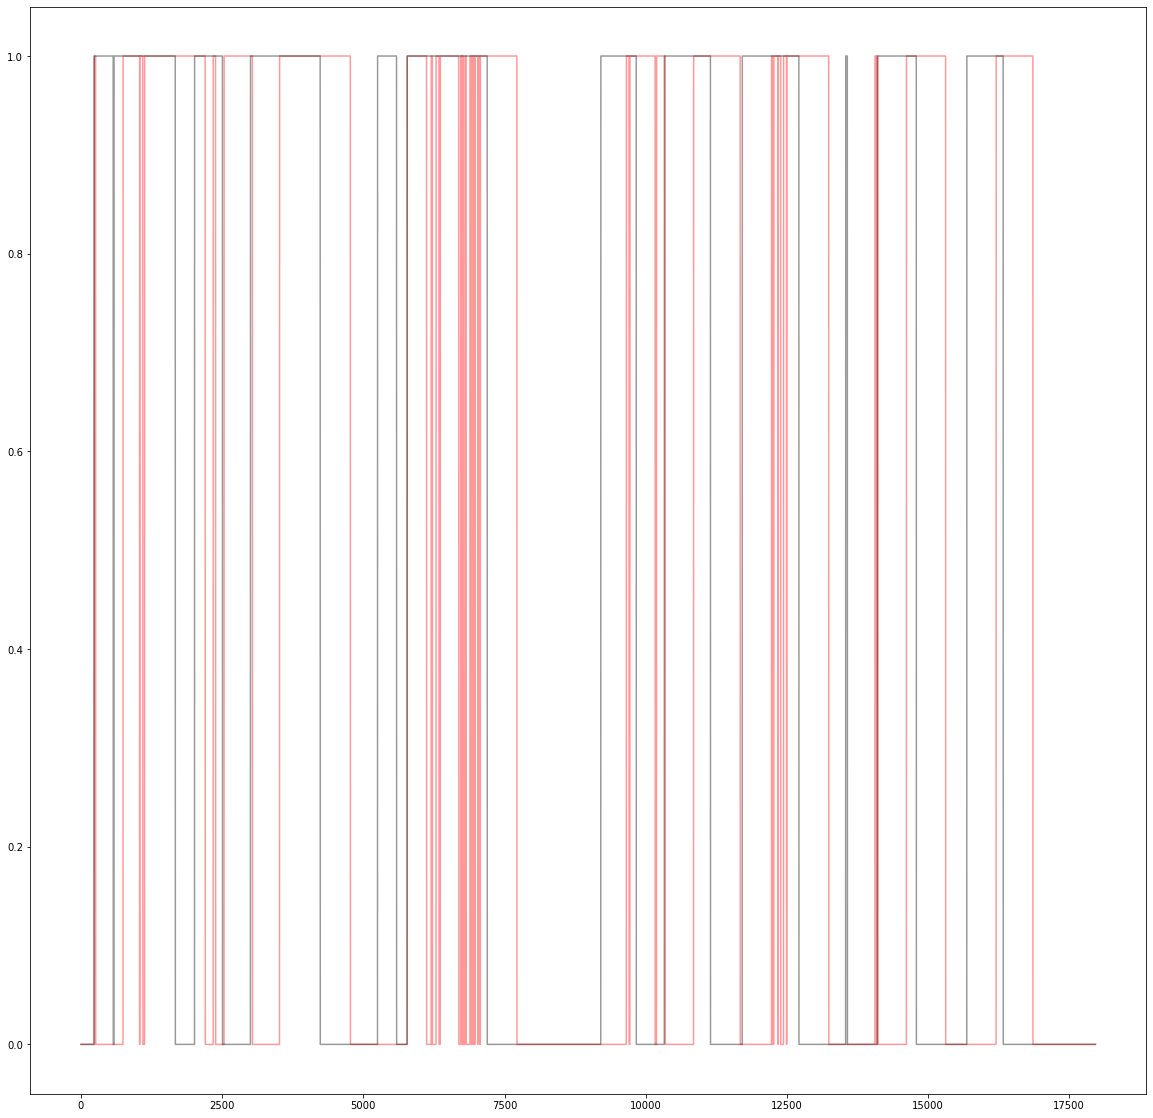

In [157]:
start=400
inc=400
plt.figure(figsize=(20,20))
plt.plot(aligned_df.in_box,'r',alpha=.4)
plt.plot(aligned_df.annots.in_light,'k',alpha=.4)
#plt.xlim([start,start+inc])

## building a classifier, random forest

### ANNOTATION IMPORT

In [91]:
annots_rears=pd.DataFrame()

for idx in annots.index:
    if "rear" in annots.Behavior[idx]:
        annots_rears=pd.concat([annots_rears,annots[annots.index==idx]],axis=0)

annots_rears=annots_rears.reset_index().drop(columns='index')

In [92]:
## add anns to df
aligned_df['annots','rear_supported']=float(0)
aligned_df['annots','rear_unsupported']=float(0)

In [93]:
for idx in np.arange(0,len(annots_rears),2):
    val1=int(round(annots_rears.adj_frame[idx]))
    val2=int(round(annots_rears.adj_frame[idx+1]))
    if "nsupported" in annots_rears.Behavior[idx]:
        #unsupported
        aligned_df.iloc[val1:val2,-1]=1
    else:
        #supported
        aligned_df.iloc[val1:val2,-2]=1

AttributeError: 'DataFrame' object has no attribute 'adj_frame'

In [50]:
# make subsetted dataframe with just jumps
annots_jumps=pd.DataFrame()

for idx in annots.index:
    if "ump" in annots.Behavior[idx]:
        annots_jumps=pd.concat([annots_jumps,annots[annots.index==idx]],axis=0)

annots_jumps=annots_jumps.reset_index().drop(columns='index')
aligned_df['annots','jumps']=float(0)
for idx in np.arange(0,len(annots_jumps)):
    val1=int(round(annots_jumps.adj_frame[idx]-1))
    val2=int(round(annots_jumps.adj_frame[idx]+5))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999807  500.0  500.0   0.999425  0.000000e+00   
1      0.000000e+00  500.0   0.999832  500.0  500.0   0.999105  0.000000e+00   
2      0.000000e+00  500.0   0.999849  500.0  500.0   0.998960  5.693558e-14   
3      0.000000e+00  500.0   0.999859  500.0  500.0   0.999381  1.138557e-13   
4      5.760037e-14  500.0   0.999788  500.0  500.0   0.999701  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17959  0.000000e+00  500.0   0.999835  500.0  500.0   0.999936  5.755170e-14   
17960  5.812110e-14  500.0   0.999849  500.0  500.0   0.999925  5.755086e-14   
17961  0.000000e+00  500.0   0.999856  500.0  500.0   0.999932  5.755119e-14   
17962  0.000000e+00  500.0   0.999817  500.0  500.0   0.999890  5.755169e-14   
17963  1.162559e-13  500.0   0.999817  500.0  500.0   0.999934  0.000000e+00   

                               box_tr  ...              dists  \
                  y likelihood      x  ... nose_paw_left_back   
0      7.117104e-15   0.999978  500.0  ...                NaN   
1      7.117825e-15   0.999977  500.0  ...                NaN   
2     -7.116947e-15   0.999986  500.0  ...                NaN   
3      0.000000e+00   0.999985  500.0  ...                NaN   
4      7.115562e-15   0.999982  500.0  ...                NaN   
...             ...        ...    ...  ...                ...   
17959  1.438793e-14   0.999932  500.0  ...                NaN   
17960  0.000000e+00   0.999925  500.0  ...                NaN   
17961  0.000000e+00   0.999916  500.0  ...                NaN   
17962 -7.193961e-15   0.999898  500.0  ...                NaN   
17963  0.000000e+00   0.999898  500.0  ...                NaN   

                                                                    \
      nose_paw_left_front nose_paw_right_back nose_paw_right_front   
0                     NaN                 NaN                  NaN   
1                     NaN                 NaN                  NaN   
2                     NaN                 NaN                  NaN   
3                     NaN                 NaN                  NaN   
4                     NaN                 NaN                  NaN   
...                   ...                 ...                  ...   
17959                 NaN                 NaN                  NaN   
17960                 NaN           39.456385                  NaN   
17961                 NaN           40.143779                  NaN   
17962                 NaN           40.469550                  NaN   
17963                 NaN           39.421078                  NaN   

                                                 speed         annots  \
      nose_tail_tip nose_tail_base Unnamed: 54_level_1 rear_supported   
0               NaN            NaN            0.000000            0.0   
1               NaN            NaN                 NaN            0.0   
2               NaN            NaN                 NaN            0.0   
3               NaN            NaN                 NaN            0.0   
4               NaN            NaN                 NaN            0.0   
...             ...            ...                 ...            ...   
17959           NaN            NaN            4.387804            0.0   
17960           NaN            NaN            5.448547            0.0   
17961           NaN            NaN            2.683241            0.0   
17962           NaN            NaN            1.656397            0.0   
17963           NaN            NaN            0.654721            0.0   

                              
      rear_unsupported jumps  
0                  0.0   0.0  
1                  0.0   0.0  
2                  0.0   0.0  
3                  0.0   0.0  
4                  0.0   0.0  
...                ...   ...  
17959            

In [89]:
aligned_df['dists','nose_ear_right']=float(0)
aligned_df['dists','nose_ear_left']=float(0)
aligned_df['dists','nose_paw_left_back']=float(0)
aligned_df['dists','nose_paw_left_front']=float(0)
aligned_df['dists','nose_paw_right_back']=float(0)
aligned_df['dists','nose_paw_right_front']=float(0)
aligned_df['dists','nose_tail_tip']=float(0)
aligned_df['dists','nose_tail_base']=float(0)
aligned_df['speed']=float(0)

for idx in aligned_df.index:
    if idx%1000==0:
        print("on idx {} of {}".format(idx,aligned_df.index[-1]))
    rel_idx = idx-aligned_df.index[0]
    if rel_idx > 0:
        speed = math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.nose.x[idx-1],aligned_df.nose.y[idx-1]])
    else:
        speed=0
    aligned_df.iloc[rel_idx,-1]=speed
    aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
    aligned_df.iloc[rel_idx,-3]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_tip.x[idx],aligned_df.tail_tip.y[idx]])
    aligned_df.iloc[rel_idx,-4]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_front.x[idx],aligned_df.paw_right_front.y[idx]])
    aligned_df.iloc[rel_idx,-5]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_back.x[idx],aligned_df.paw_right_back.y[idx]])
    aligned_df.iloc[rel_idx,-6]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_front.x[idx],aligned_df.paw_left_front.y[idx]])
    aligned_df.iloc[rel_idx,-7]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_back.x[idx],aligned_df.paw_left_back.y[idx]])
    aligned_df.iloc[rel_idx,-8]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_left.x[idx],aligned_df.ear_left.y[idx]])
    aligned_df.iloc[rel_idx,-9]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_right.x[idx],aligned_df.ear_right.y[idx]])
    
    
aligned_df

on idx 0 of 14420
on idx 1000 of 14420
on idx 2000 of 14420
on idx 3000 of 14420
on idx 4000 of 14420
on idx 5000 of 14420
on idx 6000 of 14420
on idx 7000 of 14420
on idx 8000 of 14420
on idx 9000 of 14420
on idx 10000 of 14420
on idx 11000 of 14420
on idx 12000 of 14420
on idx 13000 of 14420
on idx 14000 of 14420


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0     -2.243271e-13  500.0   0.999694  500.0  500.0   0.998650 -3.389650e-13   
1     -1.119552e-13  500.0   0.999684  500.0  500.0   0.998445 -1.128578e-13   
2      0.000000e+00  500.0   0.999678  500.0  500.0   0.998847  0.000000e+00   
3      2.234336e-13  500.0   0.999718  500.0  500.0   0.998613  1.127140e-13   
4      0.000000e+00  500.0   0.999707  500.0  500.0   0.998745  1.127083e-13   
...             ...    ...        ...    ...    ...        ...           ...   
14416  0.000000e+00  500.0   0.999753  500.0  500.0   0.198465  0.000000e+00   
14417  0.000000e+00  500.0   0.999752  500.0  500.0   0.189202  0.000000e+00   
14418  0.000000e+00  500.0   0.999631  500.0  500.0   0.205819  2.051288e-13   
14419 -1.992907e-13  500.0   0.999740  500.0  500.0   0.184471 -2.051146e-13   
14420  0.000000e+00  500.0   0.999767  500.0  500.0   0.163525  0.000000e+00   

                               box_tr  ...   tail_tip          dists  \
                  y likelihood      x  ... likelihood nose_ear_right   
0      0.000000e+00   0.999966  500.0  ...   0.017635            NaN   
1     -1.128578e-13   0.999971  500.0  ...   0.014370            NaN   
2     -5.635446e-14   0.999968  500.0  ...   0.014855            NaN   
3     -5.635702e-14   0.999967  500.0  ...   0.014145            NaN   
4      0.000000e+00   0.999967  500.0  ...   0.010465            NaN   
...             ...        ...    ...  ...        ...            ...   
14416 -1.025832e-13   0.999979  500.0  ...   0.995354      29.007572   
14417 -5.128718e-14   0.999979  500.0  ...   0.995839      29.776314   
14418  0.000000e+00   0.999980  500.0  ...   0.996005      29.799916   
14419 -5.127864e-14   0.999985  500.0  ...   0.996222      30.591426   
14420 -5.127537e-14   0.999985  500.0  ...   0.995707      29.019459   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
14416     28.323011                NaN                 NaN   
14417     29.883591                NaN                 NaN   
14418     29.799977                NaN                 NaN   
14419     30.462051                NaN                 NaN   
14420     29.305721                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
14416                 NaN                  NaN    130.543273      73.514611   
14417                 NaN                  NaN    131.014353      74.163434   
14418                 NaN                  NaN    131.174925      74.198612   
14419                 NaN                  NaN    132.896570      75.614895   
14420                 NaN                  NaN    131.523610      73.799962   

          speed  
                 
0      0.000000  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
14416  2.701311  
14417  1.405295  
14418  0.182430  
14

In [114]:
aligned_df.to_csv(filename[:-4]+"_aligned_dists.csv")

### make training and test data

In [115]:
#aligned_df_39=aligned_df.copy()
#new_aligned_df=aligned_df.copy()
#old_aligned_df=pd.read_csv('/Users/dennise/Downloads/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned_dists.csv',index_col=0,header=[0,1])

In [116]:
#aligned_df.to_csv(filename[:-4]+'_aligned_dists_annots.csv')

In [158]:
num=5

In [166]:
aligned_df=pd.read_csv('../data/40DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned_dists.csv'.format(num),index_col=0,header=[0,1])
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999682  500.0  500.0   0.999924  0.000000e+00   
1     -5.805150e-14  500.0   0.999597  500.0  500.0   0.999915 -5.753010e-14   
2      0.000000e+00  500.0   0.999493  500.0  500.0   0.999867 -5.755481e-14   
3     -5.806868e-14  500.0   0.999349  500.0  500.0   0.999889  0.000000e+00   
4      0.000000e+00  500.0   0.999385  500.0  500.0   0.999921  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17964  6.074761e-14  500.0   0.999713  500.0  500.0   0.999569  0.000000e+00   
17965 -6.074775e-14  500.0   0.999745  500.0  500.0   0.999388  0.000000e+00   
17966  0.000000e+00  500.0   0.999626  500.0  500.0   0.999576 -5.884656e-14   
17967  6.074882e-14  500.0   0.999739  500.0  500.0   0.999666  0.000000e+00   
17968 -1.215010e-13  500.0   0.999814  500.0  500.0   0.999504 -5.884342e-14   

                               box_tr  ...   tail_tip          dists  \
                  y likelihood      x  ... likelihood nose_ear_right   
0     -1.438010e-14   0.999937  500.0  ...   0.038663            NaN   
1      1.438252e-14   0.999944  500.0  ...   0.033272            NaN   
2      4.316611e-14   0.999947  500.0  ...   0.035207            NaN   
3     -1.438739e-14   0.999926  500.0  ...   0.029825            NaN   
4     -1.438572e-14   0.999911  500.0  ...   0.038245            NaN   
...             ...        ...    ...  ...        ...            ...   
17964  7.356186e-15   0.999946  500.0  ...   0.016658      19.872170   
17965  1.471223e-14   0.999946  500.0  ...   0.018624      19.965950   
17966  0.000000e+00   0.999939  500.0  ...   0.013779      19.085971   
17967  0.000000e+00   0.999948  500.0  ...   0.082493      20.043240   
17968 -7.355427e-15   0.999954  500.0  ...   0.119596      21.363384   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
17964     21.152226          18.468724            7.582123   
17965     21.746592          18.565256           10.801351   
17966     20.889186          18.801576           13.657999   
17967     21.976734          22.634444           17.651501   
17968     23.063849          28.457000           23.284891   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17964           36.440874            40.297171           NaN      54.222900   
17965           37.123063            43.670496           NaN      54.416004   
17966           37.503085            46.631124           NaN      54.439051   
17967           40.632896            50.353278           NaN      57.568584   
17968           44.452405            55.405818           NaN      62.092825   

                    speed  
      Unnamed: 54_level_1  
0                0.000000  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
... 

In [167]:
df_for_training=pd.concat([aligned_df['dists'],aligned_df['speed']],axis=1)
df_for_training.columns

Index(['nose_ear_right', 'nose_ear_left', 'nose_paw_left_back',
       'nose_paw_left_front', 'nose_paw_right_back', 'nose_paw_right_front',
       'nose_tail_tip', 'nose_tail_base', 'Unnamed: 54_level_1'],
      dtype='object')

In [168]:
df_for_training_annots=aligned_df.annots
df_for_training_annots

AttributeError: 'DataFrame' object has no attribute 'annots'

In [55]:
print(np.sum(df_for_training_annots.jumps))
print(np.sum(df_for_training_annots.rear_supported))
print(np.sum(df_for_training_annots.rear_unsupported))

786.0
906.0
864.0


In [54]:
from sklearn.ensemble import RandomForestClassifier

In [147]:
xVar=df_for_training.columns
yVar=df_for_training_annots.rear_supported
df_for_training=df_for_training.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14379, 9) (14379,)
(3595, 9) (3595,)


# try kmeans

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only on X_train
scaler.fit(X_train)

# Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
scaled_df=pd.DataFrame(X_train,columns=df_for_training.columns)
cols=list(scaled_df.columns)
cols[-1]='speed'
scaled_df.columns=cols

In [87]:
scaled_df

,nose_ear_right,nose_ear_left,nose_paw_left_back,nose_paw_left_front,nose_paw_right_back,nose_paw_right_front,nose_tail_tip,nose_tail_base,speed
0,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
1,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
2,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
3,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
4,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
...,...,...,...,...,...,...,...,...,...
14374,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
14375,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
14376,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473
14377,-0.63678,-0.635264,-0.325968,-0.183475,-0.422366,-0.289653,-0.559641,-0.609092,-0.405473


In [132]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [133]:
y_pred=classifier.predict(X_test)
acc =  classifier.score(X_test, y_test)
acc

0.9696801112656467

In [134]:
import seaborn as sns

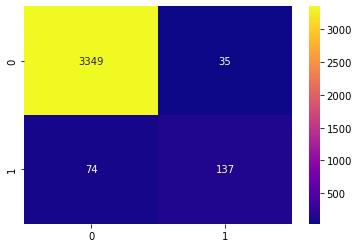

In [135]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

In [136]:
colors=classifier.predict(df_for_training)

C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


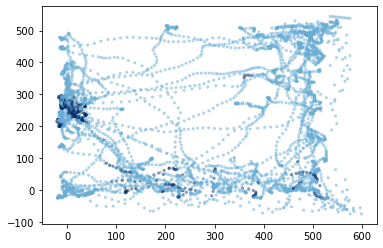

In [137]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=colors,s=5,cmap="Blues",alpha=.4)
plt.clim([-1,1])

Text(0.5, 1.0, 'ground truth in dark blue')

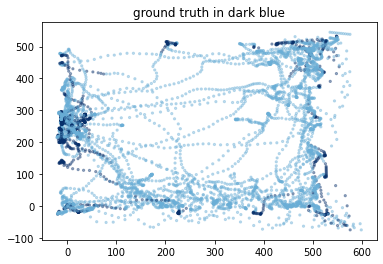

In [138]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

# try random forest

In [148]:
clf = RandomForestClassifier(n_jobs=4, random_state=0)

clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,3333,18
1.0,79,165


In [149]:
#rear_unsupported_rf=clf
#rear_supported_rf=clf
#jumps_rf=clf

In [150]:
#aligned_df=new_aligned_df.copy()

In [151]:
df_for_testing=pd.concat([aligned_df['dists'],aligned_df['speed']],axis=1)

In [152]:
preds_to_plot=clf.predict(df_for_training.fillna(0))

Text(0.5, 1.0, 'predicted in dark blue')

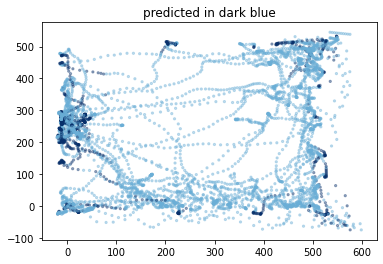

In [153]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=preds_to_plot,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('predicted in dark blue')

Text(0.5, 1.0, 'ground truth in dark blue')

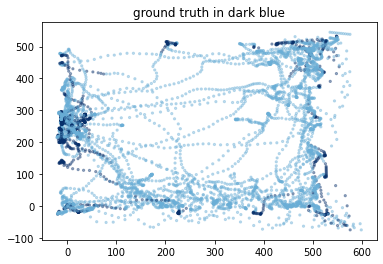

In [154]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

Text(0.5, 1.0, 'predicted in yellow, ground truth in cyan')

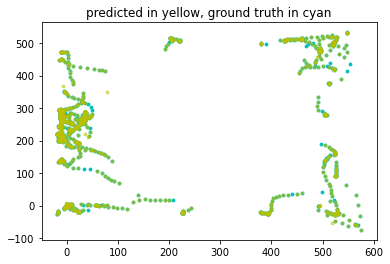

In [158]:
plt.scatter(aligned_df.nose.x[yVar==1],aligned_df.nose.y[yVar==1],s=8,c='c')
plt.scatter(aligned_df.nose.x[preds_to_plot==1],aligned_df.nose.y[preds_to_plot==1],c='y',s=8,alpha=0.5)
plt.title('predicted in yellow, ground truth in cyan')

In [156]:
for val in aligned_df[preds_to_plot==1].index:
    print(val)

1071
2133
2134
2135
2136
2137
2139
2141
2142
2143
2144
2145
2146
2147
2185
2186
2187
2188
2189
2190
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2299
2300
2301
2303
2305
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2371
2372
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2413
2414
2415
2416
2417
2418
2419
2420
2421
2423
2424
2432
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2462
2463
2465
2466
2467
2468
2469
2470
2471
2473
2474
2475
2476
2486
2487
2488
2489
2490
2493
2494
2495
2496
2497
2498
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
3007
3008
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043


In [109]:
.9*60

54.0

In [105]:
for val in aligned_df[preds_to_plot==1].index/(30*60):
    print(val)

0.28944444444444445
0.29
0.29055555555555557
0.2911111111111111
0.2922222222222222
0.2927777777777778
0.29333333333333333
0.29388888888888887
0.29444444444444445
0.295
0.29555555555555557
0.2961111111111111
0.2966666666666667
0.2972222222222222
0.29777777777777775
0.29833333333333334
0.29888888888888887
0.29944444444444446
0.3
0.3005555555555556
0.3011111111111111
0.3016666666666667
0.3022222222222222
0.3038888888888889
0.305
0.3055555555555556
0.3061111111111111
0.30666666666666664
0.30722222222222223
0.30777777777777776
0.30833333333333335
0.3088888888888889
0.30944444444444447
0.31
0.31055555555555553
0.3111111111111111
0.31166666666666665
0.31222222222222223
0.31277777777777777
0.31333333333333335
0.3138888888888889
0.31444444444444447
0.315
0.31555555555555553
0.3161111111111111
0.31666666666666665
0.3194444444444444
0.32
0.32055555555555554
0.3211111111111111
0.32166666666666666
0.32222222222222224
0.3227777777777778
0.3233333333333333
0.3238888888888889
0.47444444444444445
0.475

In [196]:
# list features, their contribution
list(zip(X_train, clf.feature_importances_))

[('nose_ear_right', 0.08698120307662018),
 ('nose_ear_left', 0.08571484770100686),
 ('nose_paw_left_back', 0.11515330026909691),
 ('nose_paw_left_front', 0.03532464296088182),
 ('nose_paw_right_back', 0.09854245167538753),
 ('nose_paw_right_front', 0.08596267601617434),
 ('nose_tail_tip', 0.173231708714229),
 ('nose_tail_base', 0.12233163318854899),
 ('speed', 0.1967575363980544)]

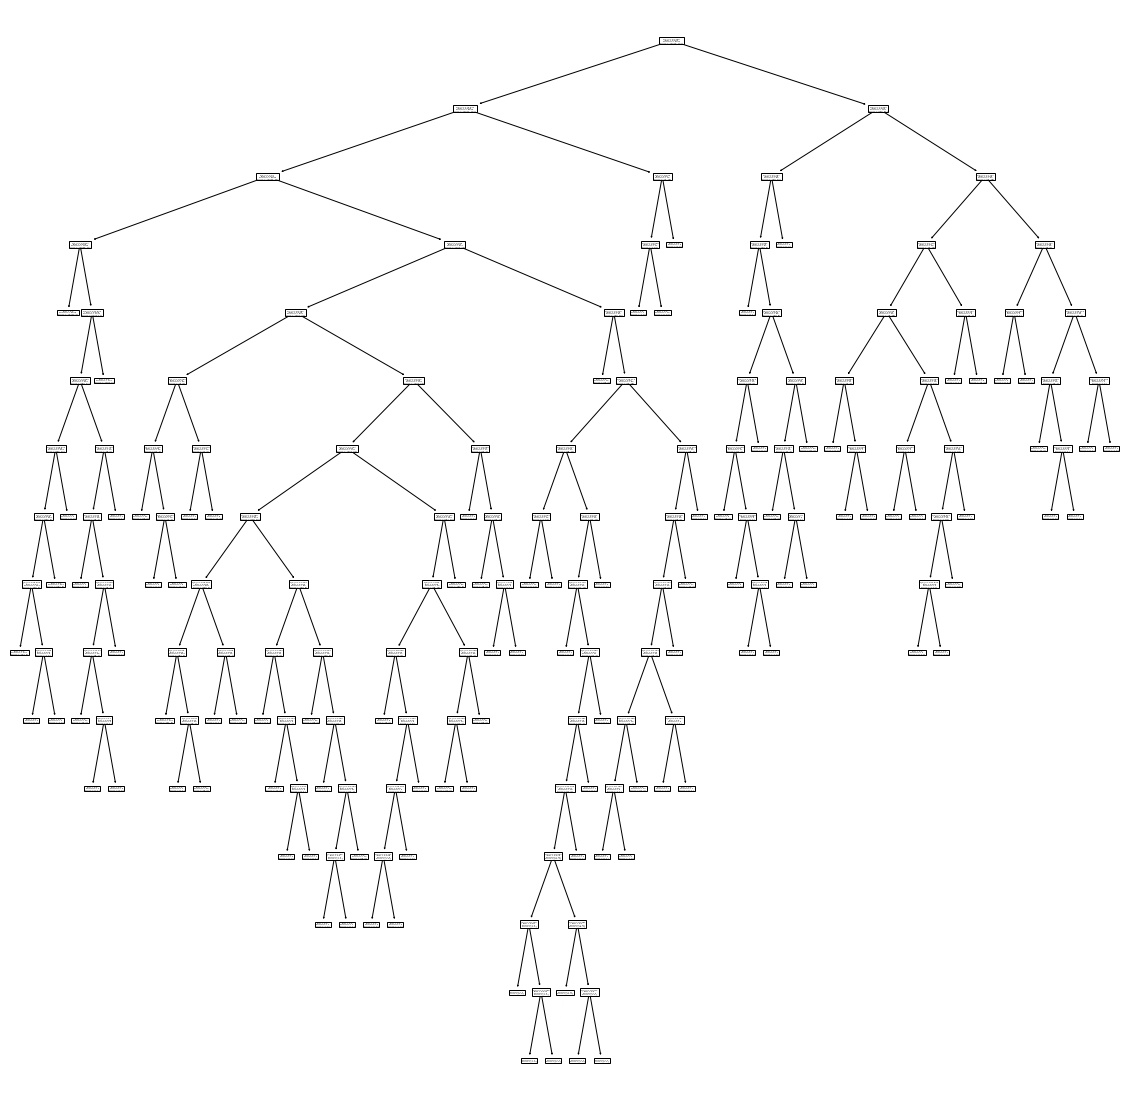

In [85]:
from sklearn import tree

plt.figure(figsize=(20,20))
_=tree.plot_tree(clf.estimators_[0])

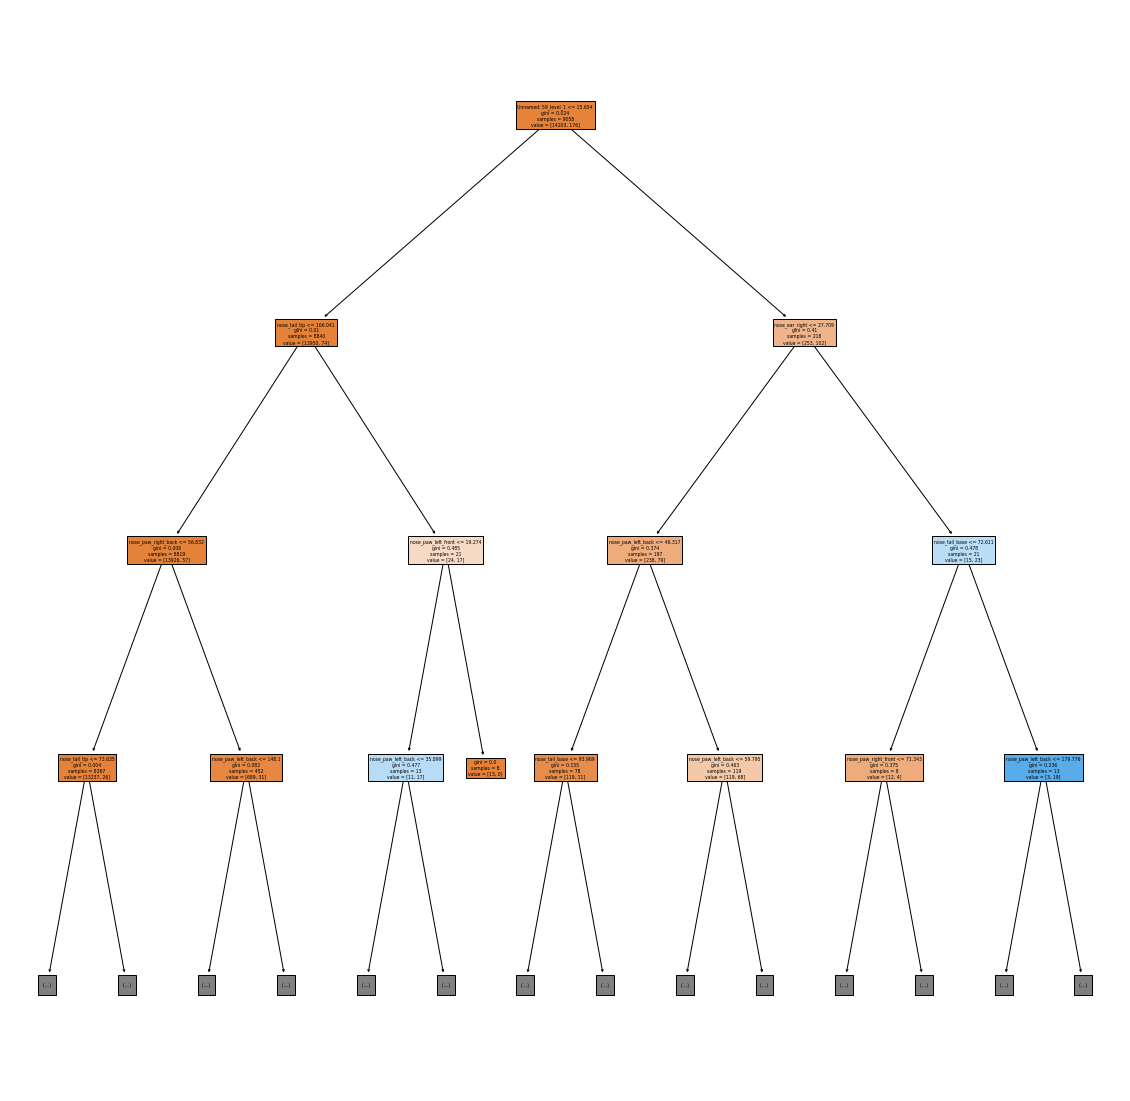

In [86]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(clf.estimators_[2], feature_names=X_train.columns, filled=True,max_depth=3)

# TODOs
- add classifier output to csv, save out
- add Alex to lab GitHub
- turn into scripts
- check additional ground truth data
- if looks good and Alex is happy, process all the videos
    - DLC analysis of video
    - run script on each output csv
    - send to Alex

# notes from Alex chat 20221125
- observer quant I need to annotate some
- re run on all the data we have
- send alex just-jumps
- Alex owes me videos and start times

In [173]:
# consider tortuosity of trajectory, speed profile

In [29]:
emily_anns = pd.read_csv('../data/video_anns_emily.csv')
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS
0,5,nose_in,1.0,17.281,29.917
1,5,ears_in,1.0,18.551,NaN
2,5,ears_in,0.0,19.654,NaN
3,5,nose_in,0.0,20.122,NaN
4,5,nose_in,1.0,31.086,NaN
...,...,...,...,...,...
524,39,jump,0.0,546.314,NaN
525,39,jump,1.0,546.715,NaN
526,39,jump,0.0,547.149,NaN
527,39,jump,1.0,556.572,NaN


In [30]:
rows_to_rm=[]
emily_anns['frame']=float(0)
fps = emily_anns.encdoed_FPS[0]
for idx in emily_anns.index:
    #print(idx)
    if np.isnan(emily_anns.encdoed_FPS[idx]):
        emily_anns.encdoed_FPS[idx]=fps
    else:
        fps = emily_anns.encdoed_FPS[idx]
    emily_anns.iloc[idx,-1]=emily_anns.time_in_sec[idx]*fps
    if np.isnan(emily_anns.start_or_stop[idx]):
        rows_to_rm.append(idx)
    elif "_in" in emily_anns.behavior[idx]:
        rows_to_rm.append(idx)


C:\Users\dennise\AppData\Local\Temp\ipykernel_15212\1030031883.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emily_anns.encdoed_FPS[idx]=fps


In [31]:
emily_anns.drop(emily_anns.index[rows_to_rm], inplace=True)
emily_anns=emily_anns.reset_index().drop(columns='index')
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS,frame
0,5,rear_supported,1.0,71.063,29.917,2125.991771
1,5,rear_supported,0.0,71.698,29.917,2144.989066
2,5,rear_supported,1.0,72.300,29.917,2162.999100
3,5,rear_supported,0.0,73.403,29.917,2195.997551
4,5,rear_supported,1.0,74.907,29.917,2240.992719
...,...,...,...,...,...,...
417,39,jump,0.0,546.314,29.926,16348.992764
418,39,jump,1.0,546.715,29.926,16360.993090
419,39,jump,0.0,547.149,29.926,16373.980974
420,39,jump,1.0,556.572,29.926,16655.973672


In [32]:
emily_anns.to_csv('../data/video_anns_emily_cleaned.csv')

In [33]:
emily_anns

,video,behavior,start_or_stop,time_in_sec,encdoed_FPS,frame
0,5,rear_supported,1.0,71.063,29.917,2125.991771
1,5,rear_supported,0.0,71.698,29.917,2144.989066
2,5,rear_supported,1.0,72.300,29.917,2162.999100
3,5,rear_supported,0.0,73.403,29.917,2195.997551
4,5,rear_supported,1.0,74.907,29.917,2240.992719
...,...,...,...,...,...,...
417,39,jump,0.0,546.314,29.926,16348.992764
418,39,jump,1.0,546.715,29.926,16360.993090
419,39,jump,0.0,547.149,29.926,16373.980974
420,39,jump,1.0,556.572,29.926,16655.973672
